# __Machine Learning for Predicting Blood Pressure Genes__ 

## Import modules:

In [1]:
import pandas as pd
import numpy as np
import numpy as numpy
from numpy import array
from numpy import argmax
np.random.seed(7) # for keras reproducibility, set before import as shown in keras examples. https://github.com/keras-team/keras/issues/2743
from sklearn import datasets, metrics, preprocessing, model_selection
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer,StandardScaler, LabelEncoder, OneHotEncoder 
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, mean_squared_error, matthews_corrcoef
from sklearn.datasets import make_classification, load_digits
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression, LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier


import dask_ml.model_selection as dcv

import matplotlib
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import regularizers
from keras.regularizers import l1
reg = l1(0.001)


import eli5
from eli5.sklearn import PermutationImportance
from itertools import cycle
from scipy import interp

Using TensorFlow backend.


## Load data:

In [2]:
dataset= pd.read_csv('BP_training.csv')
data = dataset.drop(["gene"],1)
print(data.shape)

(303, 40)


# Data preprocessing
### 1. Impute missing values by mean imputation for individual features

### 2. Encode blood pressure gene categories from strings to floats: 
4 categories of affect on BP: certain, likely, possible, unlikely

In [3]:
df = data.iloc[:,0:39]
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
imputer = imputer.fit(df)
df = imputer.transform(df)
X = MinMaxScaler().fit_transform(df)
le = preprocessing.LabelEncoder()

#convert the categorical columns into numeric
encoded_value = le.fit_transform(["certain", "likely", "possible", "unlikely"])

print(encoded_value)

Y = le.fit_transform(data["category"])

[0 1 2 3]


# Building Models:

### Hyper-parameter tuning with gridsearchCV, dask parallel processing for efficiency

In [12]:
seed = 7

logreg = LogisticRegression(penalty='l1', solver='liblinear',multi_class='auto',random_state=seed)
LR_par= {'penalty':['l1'], 'C': [0.5, 1, 5, 10], 'max_iter':[500, 1000, 5000]}

rfc =RandomForestClassifier(n_estimators=100,random_state=seed)
param_grid = {"max_depth": [5],
             "max_features": ["auto", "sqrt"],
              "min_samples_split": [50],
              "min_samples_leaf": [50],
              "bootstrap": [False, True],
              "criterion": ["entropy","gini"]}

gbm = GradientBoostingClassifier(random_state=seed)
param = {"loss":["deviance"],
    "learning_rate": [0.001, 0.01],
    "min_samples_split": [50],
    "min_samples_leaf": [50],
    "max_depth":[5],
    "max_features":["auto"],
    "criterion": ["friedman_mse"],
    "n_estimators":[1000]
    }


XGB = XGBClassifier(num_class=4)
xgb_parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['multi:softprob'],
              'learning_rate': [0.01, 0.001], #so called `eta` value
              'max_depth': [5],
              'min_child_weight': [11],
              'silent': [1],
              'subsample': [1.0],
              'colsample_bytree': [0.6],
              'n_estimators': [1000],
              'missing':[-999],
              'seed': [7]}
                   

mlp = MLPClassifier(random_state=seed)
parameter_space = {'hidden_layer_sizes': [(50,)],
     'activation': ['relu'],
     'solver': ['adam'],
     'max_iter': [10000],
     'alpha': [0.001, 0.01],
     'learning_rate': ['constant']}

svm = SVC(gamma="scale", probability=True,random_state=seed)
tuned_parameters = {'kernel':('linear', 'rbf'), 'C':(0.1, 0.25, 0.5, 0.75, 1.0)}



def baseline_model(learn_rate=0.01):
    model = Sequential()
    model.add(Dense(100, input_dim=X.shape[1], activation='relu', activity_regularizer=l1(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(75, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(50, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(25, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

keras = KerasClassifier(build_fn=baseline_model,batch_size=32, epochs=100, verbose=0)

learn_rate = [0.001, 0.01]
kerasparams = dict(learn_rate=learn_rate)


inner_cv = KFold(n_splits=5, shuffle=True, random_state=seed)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=seed)

models = []
models.append(('LR', dcv.GridSearchCV(logreg, LR_par, cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('SVM', dcv.GridSearchCV(svm, tuned_parameters, cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('RF', dcv.GridSearchCV(rfc, param_grid, cv=inner_cv,iid=False, n_jobs=-1)))
models.append(('GBM', dcv.GridSearchCV(gbm, param, cv=inner_cv,iid=False, n_jobs=-1)))
models.append(('XGB',dcv.GridSearchCV(XGB, xgb_parameters,  cv=inner_cv, iid=False, n_jobs=-1)))
models.append(('MLP', dcv.GridSearchCV(mlp, parameter_space, cv=inner_cv,iid=False, n_jobs=-1)))
models.append(('Keras', GridSearchCV(estimator=keras, param_grid=kerasparams, cv=inner_cv,iid=False, n_jobs=-1)))

results = []
names = []
scoring = 'accuracy'



X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Model Evaluation:
### Nested k-fold cross-validation (k=10)

Nested CV Accuracy LR: 67.021858 (+/- 6.719667 )
Test set accuracy: 72.13 %
Best Parameters: 
{'C': 0.5, 'max_iter': 500, 'penalty': 'l1'}

Nested CV Accuracy SVM: 65.699454 (+/- 6.643326 )
Test set accuracy: 67.21 %
Best Parameters: 
{'C': 1.0, 'kernel': 'rbf'}

Nested CV Accuracy RF: 65.071038 (+/- 8.548003 )
Test set accuracy: 67.21 %
Best Parameters: 
{'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50}

Nested CV Accuracy GBM: 71.644809 (+/- 4.440186 )
Test set accuracy: 67.21 %
Best Parameters: 
{'criterion': 'friedman_mse', 'learning_rate': 0.01, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 1000}

Nested CV Accuracy XGB: 71.650273 (+/- 5.977817 )
Test set accuracy: 72.13 %
Best Parameters: 
{'colsample_bytree': 0.6, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1000, 'nthre

D:\Anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Nested CV Accuracy Keras: 65.688525 (+/- 8.051100 )
Test set accuracy: 59.02 %
Best Parameters: 
{'learn_rate': 0.01}



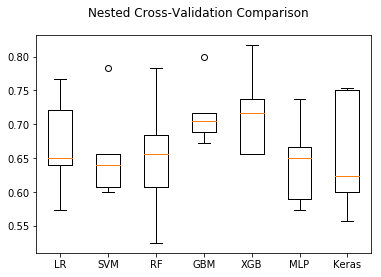

[array([0.57377049, 0.72131148, 0.63934426, 0.76666667, 0.65      ]), array([0.6557377 , 0.60655738, 0.63934426, 0.78333333, 0.6       ]), array([0.52459016, 0.60655738, 0.6557377 , 0.78333333, 0.68333333]), array([0.67213115, 0.70491803, 0.68852459, 0.8       , 0.71666667]), array([0.6557377 , 0.73770492, 0.6557377 , 0.81666667, 0.71666667]), array([0.59016393, 0.73770492, 0.57377049, 0.66666667, 0.65      ]), array([0.62295082, 0.75409836, 0.55737705, 0.75      , 0.6       ])]


In [13]:
for name, model in models:
    nested_cv_results = model_selection.cross_val_score(model, X, Y, cv=outer_cv, scoring=scoring)
    results.append(nested_cv_results)
    names.append(name)
    msg = "Nested CV Accuracy %s: %f (+/- %f )" % (name, nested_cv_results.mean()*100, nested_cv_results.std()*100)
    print(msg)
    model.fit(X_train, Y_train)
    print('Test set accuracy: {:.2f}'.format(model.score(X_test, Y_test)*100),  '%')
    print("Best Parameters: \n{}\n".format(model.best_params_))

fig = plt.figure()
fig.suptitle('Nested Cross-Validation Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

print(results)

In [14]:
for name, model in models:
    model.fit(X_train, Y_train)
    y_pred = model.predict(X_test)
    target_names=['Certain', 'Likely', 'Possible', 'Unlikely']
    print(name, 'report:','\n', classification_report(Y_test, y_pred, target_names=target_names))
    print(name, 'MCC:', matthews_corrcoef(Y_test, y_pred)) 


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


LR report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.59      0.84      0.70        19
    Possible       0.50      0.31      0.38        13
    Unlikely       0.92      0.96      0.94        25

    accuracy                           0.72        61
   macro avg       0.50      0.53      0.50        61
weighted avg       0.67      0.72      0.68        61

LR MCC: 0.5913104673680332


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


SVM report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.58      0.74      0.65        19
    Possible       0.31      0.31      0.31        13
    Unlikely       0.96      0.92      0.94        25

    accuracy                           0.67        61
   macro avg       0.46      0.49      0.47        61
weighted avg       0.64      0.67      0.65        61

SVM MCC: 0.5157924292439348


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RF report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.51      0.95      0.67        19
    Possible       0.00      0.00      0.00        13
    Unlikely       0.88      0.92      0.90        25

    accuracy                           0.67        61
   macro avg       0.35      0.47      0.39        61
weighted avg       0.52      0.67      0.58        61

RF MCC: 0.5505273568223312
GBM report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.59      0.68      0.63        19
    Possible       0.36      0.38      0.37        13
    Unlikely       0.96      0.92      0.94        25

    accuracy                           0.67        61
   macro avg       0.48      0.50      0.49        61
weighted avg       0.65      0.67      0.66        61

GBM MCC: 0.5174275326956864


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


XGB report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.67      0.74      0.70        19
    Possible       0.46      0.46      0.46        13
    Unlikely       0.89      0.96      0.92        25

    accuracy                           0.72        61
   macro avg       0.50      0.54      0.52        61
weighted avg       0.67      0.72      0.69        61

XGB MCC: 0.5846864267950294
MLP report: 
               precision    recall  f1-score   support

     Certain       0.00      0.00      0.00         4
      Likely       0.47      0.47      0.47        19
    Possible       0.16      0.23      0.19        13
    Unlikely       0.95      0.84      0.89        25

    accuracy                           0.54        61
   macro avg       0.40      0.39      0.39        61
weighted avg       0.57      0.54      0.55        61

MLP MCC: 0.3361064394597724
Keras report: 
               precision    rec

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Testing models overfitting with randomised data:

In [15]:
arr = np.arange(24000).reshape((600, 40))
random = np.random.permutation(arr)
ran = np.random.randint(4, size=600)
rand = np.column_stack((random, ran))
print(rand.shape)
X1 = rand[0:600,0:39]
Y1 = rand[0:600,-1]
print("Random data counts of label '0': {}".format(sum(ran==0)))
print("Random data counts of label '1': {}".format(sum(ran==1)))
print("Random data counts of label '2': {}".format(sum(ran==2)))
print("Random data counts of label '3': {}".format(sum(ran==3)))
print(X1.shape)
print(Y1.shape)
X1 = MinMaxScaler().fit_transform(X1)

X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.2, random_state=0)

(600, 41)
Random data counts of label '0': 157
Random data counts of label '1': 146
Random data counts of label '2': 149
Random data counts of label '3': 148
(600, 39)
(600,)


In [16]:
for name, model in models:
    nested_cv_results = model_selection.cross_val_score(model, X_train1, Y_train1, cv=outer_cv, scoring=scoring)
    results.append(nested_cv_results)
    names.append(name)
    msg = "Nested CV Accuracy %s: %f (+/- %f )" % (name, nested_cv_results.mean()*100, nested_cv_results.std()*100)
    print(msg)
    model.fit(X_train1, Y_train1)
    print('Test Accuracy: {:.2f}'.format(model.score(X_test1, Y_test1)*100),  '%')
    print("Best Parameters: \n{}\n".format(model.best_params_))

Nested CV Accuracy LR: 23.958333 (+/- 4.516559 )
Test Accuracy: 21.67 %
Best Parameters: 
{'C': 5, 'max_iter': 500, 'penalty': 'l1'}

Nested CV Accuracy SVM: 23.750000 (+/- 5.245699 )
Test Accuracy: 24.17 %
Best Parameters: 
{'C': 0.1, 'kernel': 'linear'}

Nested CV Accuracy RF: 25.625000 (+/- 3.461093 )
Test Accuracy: 30.00 %
Best Parameters: 
{'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50}

Nested CV Accuracy GBM: 25.416667 (+/- 5.043216 )
Test Accuracy: 25.00 %
Best Parameters: 
{'criterion': 'friedman_mse', 'learning_rate': 0.001, 'loss': 'deviance', 'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 50, 'min_samples_split': 50, 'n_estimators': 1000}

Nested CV Accuracy XGB: 25.625000 (+/- 5.496211 )
Test Accuracy: 20.83 %
Best Parameters: 
{'colsample_bytree': 0.6, 'learning_rate': 0.001, 'max_depth': 5, 'min_child_weight': 11, 'missing': -999, 'n_estimators': 1000, 'nthread': 4, 'object

D:\Anaconda3\envs\tensorflow\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Nested CV Accuracy Keras: 20.833333 (+/- 4.218428 )
Test Accuracy: 20.83 %
Best Parameters: 
{'learn_rate': 0.001}



# Feature Importance

- Without gridsearch due to it not working with coef and importance scikit functions


In [17]:
logreg = LogisticRegression(penalty='l1', C=0.5, max_iter=500, solver='liblinear',multi_class='auto') 
logreg.fit(X_train, Y_train)
print('All LR feature weights:')
coef_certain=logreg.coef_[0]
coef_likely=logreg.coef_[1]
coef_possible_=logreg.coef_[2]
coef_unlikely=logreg.coef_[3]
coef=logreg.coef_
intercept=logreg.intercept_
classes=logreg.classes_
print(coef)



model_features =['Catalog','CLNDN', 'InterVarautomated', 'Polyphen2_HVAR_pred','REVEL', 'SIFTpred', 'GERPrankscore', 'eigenraw', 'eigenpcraw',
                 'CADDrankscore','DANNrankscore','fathmmrankscore','fathmmpred','minP','deepseasignifscore','Exomiser.score','wgencode','regulomedscore',
                 'qvalAT','qvalLV','qvalAD', 'qvalAO','qvalTIB','qvalBL','qvalCO','qvaladiSub','qvaladiVsc','qvallung','qvalthyroid','qvalSkeletal',
                 'qvalpituit','qvalspleen', 'qvalleg', 'qvalEsoph', 'qvalstomach', 'qvalileum', 'qvalpancr', 'qvalSaliv', 'qvalhippo']

feature = pd.DataFrame(np.array(model_features))

output1 = list(coef_certain)

df = pd.DataFrame(np.array(output1))

df_total = pd.concat([feature, df], axis=1)
print("Certain coefficients:")
df_total.head(40)

All LR feature weights:
[[ 0.55564656  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.28532114  0.7507532
   0.          0.          0.          0.          0.          0.
   0.21044541  0.         -0.85625196  0.          0.          0.
   0.          0.          0.        ]
 [-0.12780575  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.         -0.84554366  0.         -0.02135656
   0.          0.         -0.88845931  0.         -0.19450433  0.
   0.60029169  0.          0.          1.00209303  0.         -0.37941679
   0.          0.11931302  1.29006958  0.          0.41244765  0.
   1.13221483  0.94441816  0.31491981]
 [ 0.44402164  0.          0.          0.          0.          0.
   0.          0.

,0,0
0,Catalog,0.555647
1,CLNDN,0.000000
2,InterVarautomated,0.000000
3,Polyphen2_HVAR_pred,0.000000
4,REVEL,0.000000
5,SIFTpred,0.000000
6,GERPrankscore,0.000000
7,eigenraw,0.000000
8,eigenpcraw,0.000000
9,CADDrankscore,0.000000


In [18]:
rfc =RandomForestClassifier(bootstrap=False, criterion='gini', max_depth=10, max_features='auto', min_samples_leaf=50, min_samples_split=50)
rfc.fit(X_train,Y_train)

importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("RFC Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))


RFC Feature ranking:
1. feature 36 (0.186342)
2. feature 38 (0.174243)
3. feature 34 (0.167475)
4. feature 32 (0.111695)
5. feature 26 (0.092615)
6. feature 33 (0.092156)
7. feature 30 (0.088425)
8. feature 14 (0.017001)
9. feature 27 (0.012405)
10. feature 28 (0.011994)
11. feature 15 (0.011828)
12. feature 22 (0.010982)
13. feature 37 (0.006936)
14. feature 29 (0.006354)
15. feature 20 (0.005459)
16. feature 16 (0.001806)
17. feature 23 (0.001757)
18. feature 35 (0.000527)
19. feature 6 (0.000000)
20. feature 8 (0.000000)
21. feature 7 (0.000000)
22. feature 3 (0.000000)
23. feature 5 (0.000000)
24. feature 4 (0.000000)
25. feature 10 (0.000000)
26. feature 2 (0.000000)
27. feature 1 (0.000000)
28. feature 9 (0.000000)
29. feature 19 (0.000000)
30. feature 11 (0.000000)
31. feature 12 (0.000000)
32. feature 13 (0.000000)
33. feature 17 (0.000000)
34. feature 18 (0.000000)
35. feature 21 (0.000000)
36. feature 24 (0.000000)
37. feature 25 (0.000000)
38. feature 31 (0.000000)
39. featu

D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [19]:
gbm = GradientBoostingClassifier(criterion='friedman_mse', learning_rate=0.01, loss='deviance', max_depth=10, max_features='auto', min_samples_leaf=50, min_samples_split=50, n_estimators=500)

gbm.fit(X_train,Y_train)

feature_importance = gbm.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

print(np.argsort(feature_importance))

importances = gbm.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print(" GBM Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[ 0 17 13 12 11 10  8  9  6  5  4  3  2  1  7 21 26 33 24 16 29 23 28 18
 35 25 22 31 14 37 19 27 15 32 34 30 36 20 38]
 GBM Feature ranking:
1. feature 38 (0.162630)
2. feature 20 (0.143572)
3. feature 36 (0.102540)
4. feature 30 (0.102159)
5. feature 34 (0.099151)
6. feature 32 (0.076635)
7. feature 15 (0.058044)
8. feature 27 (0.044745)
9. feature 19 (0.042648)
10. feature 37 (0.034958)
11. feature 14 (0.017364)
12. feature 31 (0.016550)
13. feature 22 (0.015421)
14. feature 25 (0.013181)
15. feature 35 (0.012849)
16. feature 18 (0.010020)
17. feature 28 (0.010007)
18. feature 23 (0.008457)
19. feature 29 (0.008049)
20. feature 16 (0.006942)
21. feature 24 (0.006855)
22. feature 33 (0.004811)
23. feature 26 (0.001302)
24. feature 21 (0.001108)
25. feature 7 (0.000000)
26. feature 1 (0.000000)
27. feature 2 (0.000000)
28. feature 3 (0.000000)
29. feature 4 (0.000000)
30. feature 5 (0.000000)
31. feature 6 (0.000000)
32. feature 9 (0.000000)
33. feature 8 (0.000000)
34. feature 10 (0.

In [20]:
XGB = XGBClassifier(colsample_bytree=0.6, learning_rate=0.001, max_depth=5, min_child_weight=11, missing=-999, n_estimators=1000, nthread=4, objective='multi:softprob', seed=7, silent=1, subsample=1.0)

XGB.fit(X_train,Y_train)

feature_importance = XGB.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

print(np.argsort(feature_importance))

importances = XGB.feature_importances_

indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("XGB Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

[ 9  1  2  3  4  5  6  7  8 17 10 11 12 23 16 14 21 24 13  0 35 26 29 28
 33 37 22 19 18 15 31 32 27 20 38 30 36 25 34]
XGB Feature ranking:
1. feature 34 (0.198263)
2. feature 25 (0.129527)
3. feature 36 (0.095241)
4. feature 30 (0.064993)
5. feature 38 (0.056683)
6. feature 20 (0.055852)
7. feature 27 (0.054265)
8. feature 32 (0.043217)
9. feature 31 (0.033644)
10. feature 15 (0.030014)
11. feature 18 (0.026235)
12. feature 19 (0.023550)
13. feature 22 (0.021667)
14. feature 37 (0.020541)
15. feature 33 (0.019170)
16. feature 28 (0.018504)
17. feature 29 (0.017354)
18. feature 26 (0.015698)
19. feature 35 (0.013432)
20. feature 0 (0.011945)
21. feature 13 (0.010915)
22. feature 24 (0.010598)
23. feature 21 (0.010157)
24. feature 14 (0.009828)
25. feature 16 (0.004905)
26. feature 23 (0.003802)
27. feature 12 (0.000000)
28. feature 11 (0.000000)
29. feature 10 (0.000000)
30. feature 17 (0.000000)
31. feature 8 (0.000000)
32. feature 7 (0.000000)
33. feature 6 (0.000000)
34. feature 5 

In [21]:
my_model = KerasClassifier(build_fn=baseline_model, epochs=150, batch_size=32, verbose=0)
my_model.fit(X_train, Y_train) 

perm = PermutationImportance(my_model, random_state=1).fit(X_train, Y_train)
df = pd.DataFrame(X_train)
eli5.show_weights(perm)

Weight,Feature
0.1413 ± 0.0298,x32
0.0992 ± 0.0209,x20
0.0314 ± 0.0193,x27
0.0281 ± 0.0142,x36
0.0264 ± 0.0040,x0
0.0215 ± 0.0110,x16
0.0215 ± 0.0142,x33
0.0182 ± 0.0040,x21
0.0174 ± 0.0096,x30
0.0165 ± 0.0196,x31


In [22]:
svm = SVC(gamma="scale", probability=True,random_state=seed, C=0.75, kernel='rbf')

svm.fit(X_train, Y_train) 

perm = PermutationImportance(svm, random_state=1).fit(X_train, Y_train)
df = pd.DataFrame(X_train)
eli5.show_weights(perm)

Weight,Feature
0.0421 ± 0.0160,x20
0.0355 ± 0.0170,x27
0.0231 ± 0.0112,x30
0.0223 ± 0.0206,x19
0.0174 ± 0.0184,x38
0.0149 ± 0.0153,x21
0.0149 ± 0.0066,x16
0.0140 ± 0.0243,x36
0.0132 ± 0.0062,x15
0.0116 ± 0.0205,x33


In [23]:
mlp = MLPClassifier(random_state=seed, activation='relu', alpha=0.001, hidden_layer_sizes=(50,), learning_rate='constant', max_iter=10000, solver='adam')
mlp.fit(X_train, Y_train)
mlpcoef=mlp.coefs_[0]

#print('All MLP feature weights:')
#coef=logreg.coef_[0]
#print(mlpcoef)

#output2 = list(mlpcoef)
#df = pd.DataFrame(np.array(output2))
#df_total = pd.concat([feature, df], axis=1)
#df_total.head(28)


perm = PermutationImportance(mlp, random_state=1).fit(X_train, Y_train)
df = pd.DataFrame(X_train)
eli5.show_weights(perm)

Weight,Feature
0.1653 ± 0.0188,x32
0.1050 ± 0.0457,x20
0.1025 ± 0.0169,x27
0.0653 ± 0.0218,x36
0.0587 ± 0.0121,x38
0.0579 ± 0.0117,x0
0.0512 ± 0.0178,x30
0.0496 ± 0.0148,x22
0.0339 ± 0.0081,x33
0.0331 ± 0.0173,x19


# Unknown gene prediction

In [24]:
dataset_unknown= pd.read_csv('BP_unknown.csv')
dataunknown = dataset_unknown.drop(["gene"],1)
print(dataunknown.shape)

df =dataunknown.iloc[:,0:39]
imputer = SimpleImputer(missing_values = np.nan, strategy = "mean")
imputer = imputer.fit(df)
df = imputer.transform(df)
#print(df)
X2 = MinMaxScaler().fit_transform(df)

(1990, 40)


D:\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


In [25]:
def baseline_model(learn_rate=0.01):
    model = Sequential()
    model.add(Dense(100, input_dim=X.shape[1], activation='relu', activity_regularizer=l1(0.0001)))
    model.add(Dropout(0.5))
    model.add(Dense(75, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(50, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(25, activation='relu',activity_regularizer=l1(0.0001))) 
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Nadam', metrics=['accuracy'])
    return model

keras = KerasClassifier(build_fn=baseline_model,batch_size=32, epochs=100, verbose=0)

learn_rate = [0.001, 0.01]
kerasparams = dict(learn_rate=learn_rate)


In [26]:
estimator = GridSearchCV(estimator=keras, param_grid=kerasparams, cv=inner_cv,iid=False, n_jobs=-1)

estimator.fit(X, Y)

prob1 = estimator.predict_proba(X2)[:,0]
prob2 = estimator.predict_proba(X2)[:,1]
prob3 = estimator.predict_proba(X2)[:,2]
prob4 = estimator.predict_proba(X2)[:,3]

predictions = list(estimator.predict(X2))
#predictions = estimator.predict_proba(X2)

output = pd.Series(data=predictions, index=dataset_unknown.index, name = 'Keras prediction')  
output1 = pd.Series(data=prob1, index=dataset_unknown.index, name = 'Certain') 
output2 = pd.Series(data=prob2, index=dataset_unknown.index, name = 'Likely') 
output3 = pd.Series(data=prob3, index=dataset_unknown.index, name = 'Possible') 
output4 = pd.Series(data=prob4, index=dataset_unknown.index, name = 'Unlikely') 
df_total = pd.concat([dataset_unknown, output, output1, output2, output3, output4], axis=1)


df_total.head(10)
df_total.to_csv('.\Keras_predictions.csv')

In [27]:
estimator = dcv.GridSearchCV(XGB, xgb_parameters,  cv=inner_cv, iid=False, n_jobs=-1)

estimator.fit(X, Y)

prob1 = estimator.predict_proba(X2)[:,0]
prob2 = estimator.predict_proba(X2)[:,1]
prob3 = estimator.predict_proba(X2)[:,2]
prob4 = estimator.predict_proba(X2)[:,3]

predictions = list(estimator.predict(X2))
#predictions = estimator.predict_proba(X2)

output = pd.Series(data=predictions, index=dataset_unknown.index, name = 'XGB prediction')  
output1 = pd.Series(data=prob1, index=dataset_unknown.index, name = 'Certain') 
output2 = pd.Series(data=prob2, index=dataset_unknown.index, name = 'Likely') 
output3 = pd.Series(data=prob3, index=dataset_unknown.index, name = 'Possible') 
output4 = pd.Series(data=prob4, index=dataset_unknown.index, name = 'Unlikely') 
df_total = pd.concat([dataset_unknown, output, output1, output2, output3, output4], axis=1)


df_total.head(10)

df_total.to_csv('.\XGB_predictionsnew.csv')

In [28]:
estimator = dcv.GridSearchCV(gbm, param,  cv=inner_cv, iid=False, n_jobs=-1)

estimator.fit(X, Y)

prob1 = estimator.predict_proba(X2)[:,0]
prob2 = estimator.predict_proba(X2)[:,1]
prob3 = estimator.predict_proba(X2)[:,2]
prob4 = estimator.predict_proba(X2)[:,3]

predictions = list(estimator.predict(X2))
#predictions = estimator.predict_proba(X2)

output = pd.Series(data=predictions, index=dataset_unknown.index, name = 'GBM prediction')  
output1 = pd.Series(data=prob1, index=dataset_unknown.index, name = 'Certain') 
output2 = pd.Series(data=prob2, index=dataset_unknown.index, name = 'Likely') 
output3 = pd.Series(data=prob3, index=dataset_unknown.index, name = 'Possible') 
output4 = pd.Series(data=prob4, index=dataset_unknown.index, name = 'Unlikely') 
df_total = pd.concat([dataset_unknown, output, output1, output2, output3, output4], axis=1)


df_total.head(10)

df_total.to_csv('.\GBM_predictions.csv')